# Run everything in this section to define functions and imports. 

In [1]:
# Imports. 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import numpy as np
import seaborn as sns
import csv
import matplotlib.pyplot as plt
import json
from collections import Counter
from nltk.corpus import wordnet as wn

### Define the paths below for code to run. 

In [11]:

snare_path = '/home/rcorona/obj_part_lang/snare-master/amt/folds_adversarial'
metadata_path = './data/metadata.csv'
categories_path = './data/categories.synset.csv'
lfn_feat_dir = './data/lfn_feats'
clip_feat_dir = '/home/rcorona/dev/snare-master/data/shapenet-clipViT32-frames/'

In [3]:
def get_snare_objs(): 
    """
    Get all ShapeNetSem object IDs for objects used in SNARE. 
    """
    train = json.load(open(os.path.join(snare_path, 'train.json')))
    val = json.load(open(os.path.join(snare_path, 'val.json')))
    test = json.load(open(os.path.join(snare_path, 'test.json')))

    train_objs = set()
    val_objs = set()
    test_objs = set()

    # Comb through snare files to collect unique set of ShapeNet objects. 
    snare_objs = set()

    for obj_set, split in [(train_objs, train), (val_objs, val), (test_objs, test)]:
        for datapoint in split: 
            for obj in datapoint['objects']:
                obj_set.add(obj)

    all_objs = train_objs | val_objs | test_objs

    return list(all_objs)

In [4]:
def get_plot_labels(objs):
    """
    Generate category labels for TSNE plot. 
    """
    
    # Load all metadata for objects. 
    with open(metadata_path, 'r') as csvfile: 
        metadata = [row for row in csv.reader(csvfile)]
        
    # Get index of each object in metdata. 
    obj2synset = {m[0].replace('wss.', '').strip(): m[2].strip() for m in metadata}
        
    # Load synset word mappings. 
    with open(categories_path, 'r') as csvfile: 
        mappings = [row for row in csv.reader(csvfile)]
        
        # Mapping from synset to word. 
        s2w = {r[2].strip(): r[3].split(',')[0].strip() for r in mappings[1:]}    


    # Get set of all synsets. 
    synset_codes = set([r[2].strip() for r in metadata[2:]])    
    synsets = []

    for s in synset_codes: 
        try: 
            synset = s2w[s]
        except: 
            synset = 'None'
            
        synsets.append(synset)
        

    ## Get 10 most common object categories and filter out everything else.  
    snare_synsets = []
    counts = Counter()

    # Count object categories. 
    for obj in objs:
        synset = obj2synset[obj]

        # Only count those with label. 
        if synset in s2w:
            word = s2w[synset]
            snare_synsets.append(word)
            
            # Update word count.
            if not word == '': 
                counts[word] += 1
        else: 
            snare_synsets.append(None)
            
    return snare_synsets, counts

In [5]:
def load_lfn_features(objs):
    """
    Given list of object IDs, load features for each object under LFN.  
    """
    # Load all features and name order. 
    feats = []
    
    for obj in objs:
        
        # Load feature. 
        path = os.path.join(lfn_feat_dir, '{}.npy'.format(obj))
        feat = feats.append(np.load(path))
        
    return feats

In [12]:
def load_clip_features(objs):
    """
    Given list of object IDs, load features for each object under CLIP.  
    """
    # Load all features and name order. 
    feats = []

    for obj in objs:
        
        # Load image features for object. 
        path = os.path.join(clip_feat_dir, '{}.npy'.format(obj))
        
        # Load features for input views and take mean. 
        feat = np.mean(np.load(path)[6:], axis=0)
        feats.append(feat)
        
    return feats

In [6]:
    
def filter_by_top_k(counts, feats, objs, snare_synsets):
    # Get 10 most common categories. 
    top10 = {t[0]: t[1] for t in counts.most_common(10)}

    # Only keep objects in top-10 categories. 
    final_feats = []
    final_labels = []

    assert len(objs) == len(feats) and len(objs) == len(snare_synsets)

    for i in range(len(objs)):
        synset = snare_synsets[i]
        
        if synset in top10: 
            final_feats.append(feats[i])
            final_labels.append(synset)
            
    # Create numpy array of features. 
    final_feats = np.stack(final_feats)
    print('Final feature shape: {}'.format(final_feats.shape))
    
    return final_feats, final_labels

In [7]:
# Reduce dimensionality with PCA. 
def gen_tsne_feats(final_feats):
    pca_feats = PCA(n_components=3).fit_transform(final_feats)
    print('PCA Feat shape: {}'.format(pca_feats.shape))

    # Compute TSNE features.
    tsne_feats = TSNE(n_components=2, random_state=0).fit_transform(pca_feats)
    print('TSNE Feat shape: {}'.format(tsne_feats.shape))
    
    return tsne_feats

In [14]:
def gen_plot(tsne_feats, final_labels, title):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Plot the TSNE embeddings. 
    sns.scatterplot(x=tsne_feats[:,0], y=tsne_feats[:,1], hue=final_labels, palette=sns.color_palette("hls", 10)).set(title=title)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [9]:
# Generate list of all ShapeNetSem objects used in SNARE. 
snare_objs = get_snare_objs()

# Generate category labels for TSNE plot. 
synsets, counts = get_plot_labels(snare_objs)

# LFN Feature Visualization

(2273, 256)
PCA Feat shape: (2273, 3)
TSNE Feat shape: (2273, 2)


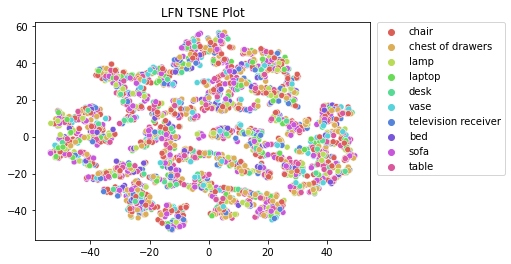

In [10]:
# Load LFN features. 
lfn_feats = load_lfn_features(snare_objs)

# Filter features by top 10 most occurring categories. 
final_feats, final_labels = filter_by_top_k(counts, lfn_feats, snare_objs, synsets)

# Generate TSNE features. 
tsne_feats = gen_tsne_feats(final_feats)

# Visualize them. 
gen_plot(tsne_feats, final_labels, title='LFN TSNE Plot')

# CLIP Feature Visualization

(2273, 512)
PCA Feat shape: (2273, 3)
TSNE Feat shape: (2273, 2)


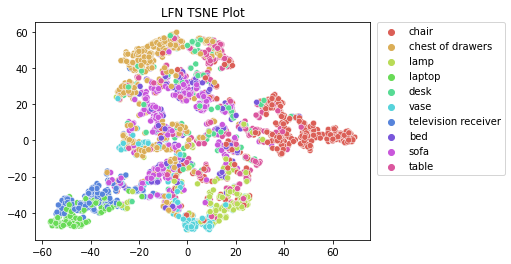

In [13]:
# Load LFN features. 
clip_feats = load_clip_features(snare_objs)

# Filter features by top 10 most occurring categories. 
final_feats, final_labels = filter_by_top_k(counts, clip_feats, snare_objs, synsets)

# Generate TSNE features. 
tsne_feats = gen_tsne_feats(final_feats)

# Visualize them. 
gen_plot(tsne_feats, final_labels, title='CLIP TSNE Plot')